In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
def read_data(url):
    df = pd.read_csv(url)
    df = df.loc[df[" utilization.gpu [%]"] > 0] #isolating training 
    #print(df.columns)
    return df

In [3]:
def time_duration(df):
    df.timestamp = [datetime.strptime(time, "%Y/%m/%d %H:%M:%S.%f") for time in df.timestamp]
    time_interval = df.iloc[-1].timestamp - df.iloc[0].timestamp
    #print("Total time in seconds: {}".format(time_interval.total_seconds()))
    return time_interval.total_seconds()

In [4]:
def power_reading(url):
    df = read_data(url)
    time_interval = time_duration(df)
    mean_power =df[' power.draw [W]'].mean() # refer notebook on time series
    total_power = mean_power * time_interval
    gpu_util = df[' utilization.gpu [%]'].mean()
    memory_util = df[' utilization.memory [%]'].mean()
    memory_used = df[' memory.used [MiB]'].mean()
    extract = url.split('/')[1].replace(".","_").split('_')
    data = []
    if (extract[2] != 'pretrain'):
        data = [extract[2], extract[3], extract[4],
                mean_power,time_interval,total_power,gpu_util,memory_util,memory_used]
#     else:
#         data = [extract[2], None, None,
#                 mean_power,time_interval,total_power,gpu_util,memory_util,memory_used]
    return df, data

In [5]:
import os
folder_name = 'nvidia'
result = pd.DataFrame(columns=['dataset','batchsize','max_seq_len',
                               'mean_power','total_time','power','gpu_util','memory_util','memory_used'])

for file_name in os.listdir(folder_name):
    #print(file_name)
    url = folder_name + '/' + file_name
    df,data = power_reading(url)
   # print (data)
    if data:
        result =result.append(pd.Series(data, index=result.columns),ignore_index=True)
    #print ("-------------------------------------------")

In [6]:
train_dataset_sizes = {
    'MRPC':3668,
    'CoLA': 8551,
    'SST-2':67349,
    'MNLI':392702,
    'STS-B':8628
}

In [7]:
result['dataset_size'] = result['dataset']
result["dataset_size"].replace(train_dataset_sizes, inplace=True)

In [40]:
result[["batchsize","max_seq_len"]] = result[["batchsize","max_seq_len"]].apply(pd.to_numeric)
result

,dataset,batchsize,max_seq_len,mean_power,total_time,power,gpu_util,memory_util,memory_used,dataset_size
0,SST-2,16,256,211.759289,493.516,104506.597464,93.373841,38.238929,6151.259526,67349
1,MRPC,28,128,204.860397,77.174,15809.896305,91.099338,34.264901,4803.768212,3668
2,SST-2,56,128,222.548349,1151.970,256369.021446,95.185530,39.189525,7789.496671,67349
3,SST-2,24,128,207.307071,1518.205,314734.632415,91.829252,32.549145,4523.066756,67349
4,MRPC,20,128,193.060506,90.725,17515.414372,90.129213,31.393258,4050.230337,3668
5,CoLA,32,256,227.781566,311.942,71054.637283,95.153344,42.350734,10323.463295,8551
6,MRPC,16,128,166.462923,98.801,16446.703263,90.353846,30.579487,3563.138462,3668
7,MRPC,64,128,223.450000,55.178,12329.524100,97.333333,41.041667,8502.500000,3668
8,MRPC,32,128,199.650667,70.170,14009.487280,92.533333,33.366667,5261.500000,3668
9,MRPC,40,128,215.501631,71.807,15474.525632,92.092199,36.510638,6020.312057,3668


In [127]:
import time
result_file = "results/result"+ str(int(time.time()))+".csv"
result.to_csv(result_file, index=False)

In [10]:
df_mrpc = result.loc[(result.dataset == 'MRPC') & (result.max_seq_len == '128')]

In [11]:
df_mrpc =df_mrpc.sort_values('batchsize')

In [12]:
df_mrpc

,dataset,batchsize,max_seq_len,mean_power,total_time,power,gpu_util,memory_util,memory_used,dataset_size
6,MRPC,16,128,166.462923,98.801,16446.703263,90.353846,30.579487,3563.138462,3668
4,MRPC,20,128,193.060506,90.725,17515.414372,90.129213,31.393258,4050.230337,3668
24,MRPC,24,128,208.408171,83.879,17481.068953,91.000000,33.286585,4435.317073,3668
1,MRPC,28,128,204.860397,77.174,15809.896305,91.099338,34.264901,4803.768212,3668
8,MRPC,32,128,199.650667,70.170,14009.487280,92.533333,33.366667,5261.500000,3668
9,MRPC,40,128,215.501631,71.807,15474.525632,92.092199,36.510638,6020.312057,3668
13,MRPC,48,128,222.867895,67.682,15084.144852,93.796992,37.819549,6779.187970,3668
23,MRPC,56,128,229.412460,63.976,14676.891561,92.515873,37.920635,7569.753968,3668
7,MRPC,64,128,223.450000,55.178,12329.524100,97.333333,41.041667,8502.500000,3668


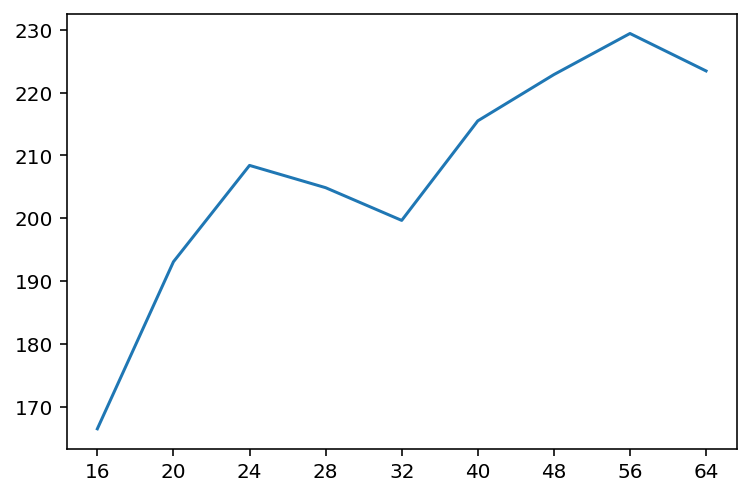

In [13]:
fig, ax = plt.subplots()
ax = plt.plot(df_mrpc['batchsize'],df_mrpc["mean_power"])

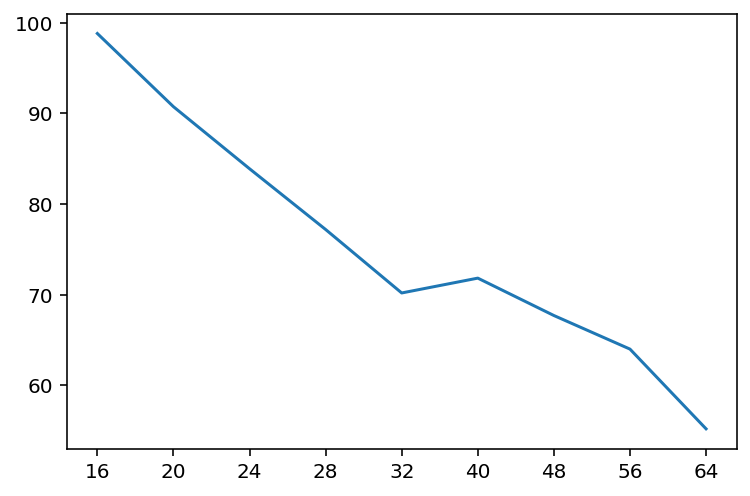

In [14]:
ax = plt.plot(df_mrpc['batchsize'],df_mrpc["total_time"])

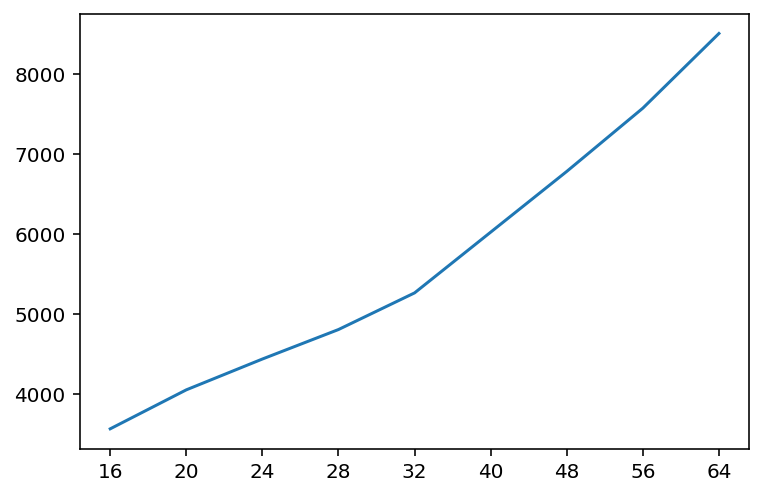

In [126]:
ax = plt.plot(df_mrpc['batchsize'],df_mrpc["memory_used"])

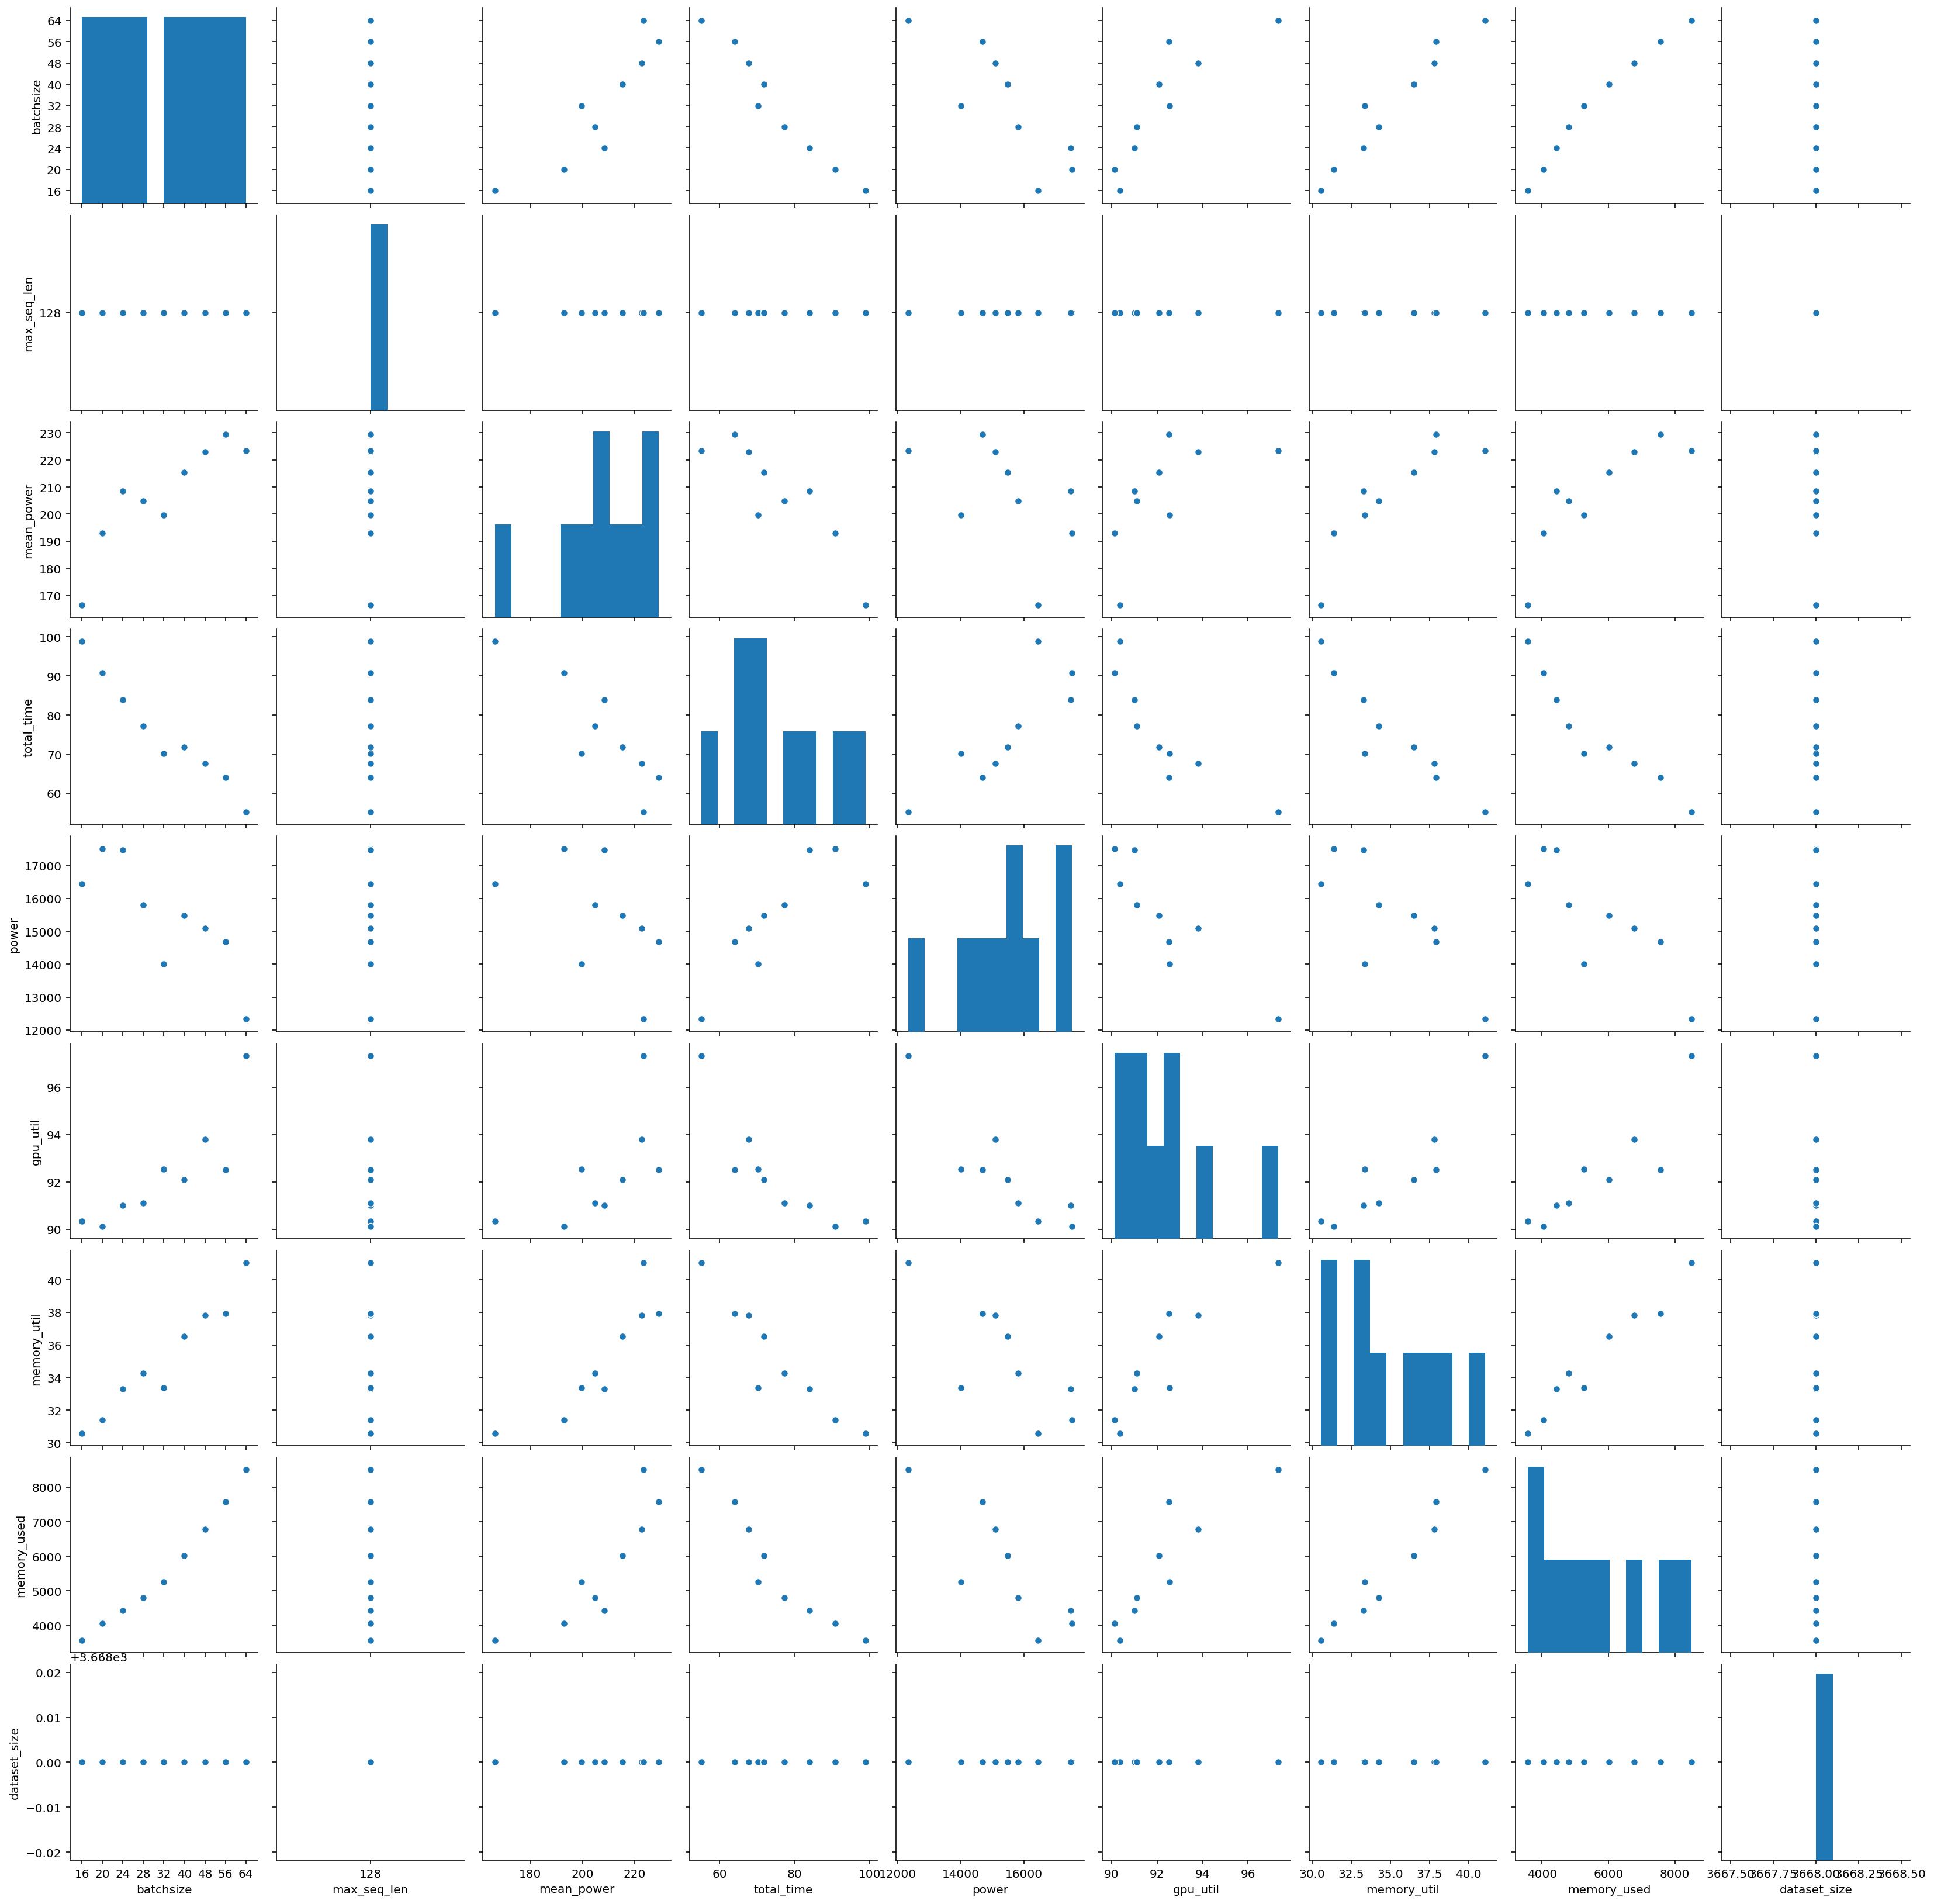

In [16]:
sns.pairplot(df_mrpc)

Increasing batch size leads to less time, better gpu util, more memory used.

Urrgghh but I knew that!


## regression model to predict time, power, gpu util, memory util

In [97]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split, KFold, cross_val_score, ShuffleSplit

In [78]:
models = dict(
    linear_reg=LinearRegression(normalize=True),
    random_forest = RandomForestRegressor(random_state=1),
    xgboost=XGBRegressor(random_state=1)
)

In [121]:
def run_models_cv(result):
    features = ['batchsize','max_seq_len','dataset_size']
    X = result[features]
    targets = ['mean_power','total_time','gpu_util','memory_util']
    cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
    for target in targets:
        y = result[target]
        #print ("________{}_________".format(target))
        
        for name, model in models.items():
            #print(name)
            scores = cross_val_score(model, X, y, cv=cv)
            yield target, name, scores

In [119]:
# features = ['batchsize','max_seq_len','dataset_size']
# X = result[features]
# y = result['mean_power']
# cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
# linear_reg=LinearRegression(normalize=True)
# scores = cross_val_score(linear_reg, X, y, cv=cv)
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.52 (+/- 0.68)


In [124]:
df_cv = pd.DataFrame(columns=("target", "model","score","std"))
for target, name, scores in run_models_cv(result):
    score_result = dict(target=target,
                       model=name,
                       score=scores.mean(),
                       std=scores.std() * 2)
    df_cv = df_cv.append(score_result,ignore_index=True)
df_cv.to_csv('results/run_models_results.csv', index=False)
df_cv

,target,model,score,std
0,mean_power,linear_reg,0.517709,0.683883
1,mean_power,random_forest,0.624529,0.337236
2,mean_power,xgboost,0.623770,0.147848
3,total_time,linear_reg,0.268991,1.607125
4,total_time,random_forest,0.108352,2.301784
5,total_time,xgboost,-0.177444,3.059197
6,gpu_util,linear_reg,0.695319,0.244976
7,gpu_util,random_forest,0.524478,0.251759
8,gpu_util,xgboost,-0.201675,1.551216
9,memory_util,linear_reg,0.905147,0.099079


Time cannot be predicted with the indicators we are using.

A pretty good indication of memory utiliation. Can almost predit gpu util and power consumption.

In [86]:
def run_models_kfold(result):
    features = ['batchsize','max_seq_len','dataset_size']
    X = result[features]
    targets = ['mean_power','total_time','gpu_util','memory_util']
    kf = KFold(n_splits=3, shuffle=True, random_state=1)
    
    for target in targets:
        y = result[target]
        #print ("________{}_________".format(target))
        fold_id = 0
        for train_index, test_index in kf.split(X):
            
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            for name, model in models.items():
                #print(name)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                r2 = r2_score(y_test, y_pred)
                mae = mean_absolute_error(y_test, y_pred)
                mse = mean_squared_error(y_test, y_pred)
                yield fold_id, target, name, r2, mae, sqrt(mse)
            fold_id += 1

In [87]:
df_models = pd.DataFrame(columns=('fold_id','target','model_name','r2','mean_abs_error','root_mean_sqr_error'))

In [88]:
for fold_id, target, name, r2, mae, rmse in run_models_kfold(result):
    model_result = dict(fold_id=fold_id,
                        target=target,
                        model_name=name,
                        r2=r2,
                        mean_abs_error=mae,
                        root_mean_sqr_error=rmse)
    #print(model_result)
    df_models = df_models.append(model_result,ignore_index=True)


In [89]:
df_models

,fold_id,target,model_name,r2,mean_abs_error,root_mean_sqr_error
0,0,mean_power,linear_reg,0.582643,6.878322,8.863975
1,0,mean_power,random_forest,0.754299,5.604384,6.801085
2,0,mean_power,xgboost,0.727599,4.731563,7.161081
3,1,mean_power,linear_reg,0.694433,8.842586,12.090017
4,1,mean_power,random_forest,0.549312,11.168818,14.682888
5,1,mean_power,xgboost,0.642345,9.337589,13.079932
6,2,mean_power,linear_reg,0.643684,6.926761,8.849261
7,2,mean_power,random_forest,0.200031,10.423051,13.259457
8,2,mean_power,xgboost,0.221224,9.454605,13.082642
9,0,total_time,linear_reg,0.203447,486.669473,708.652910


In [131]:
xgboost=XGBRegressor(random_state=1)
features = ['batchsize','max_seq_len','dataset_size']
X = result[features]
y = result['mean_power']
xgboost.fit(X,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=1,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [132]:
def feature_imp(model, train_X):
    feature_importances = pd.DataFrame(model.feature_importances_,
    index = train_X.columns,
    columns=['importance']).sort_values('importance', ascending=False)
    sns.barplot(data=feature_importances.reset_index(),x='importance',y='index',orient='h')

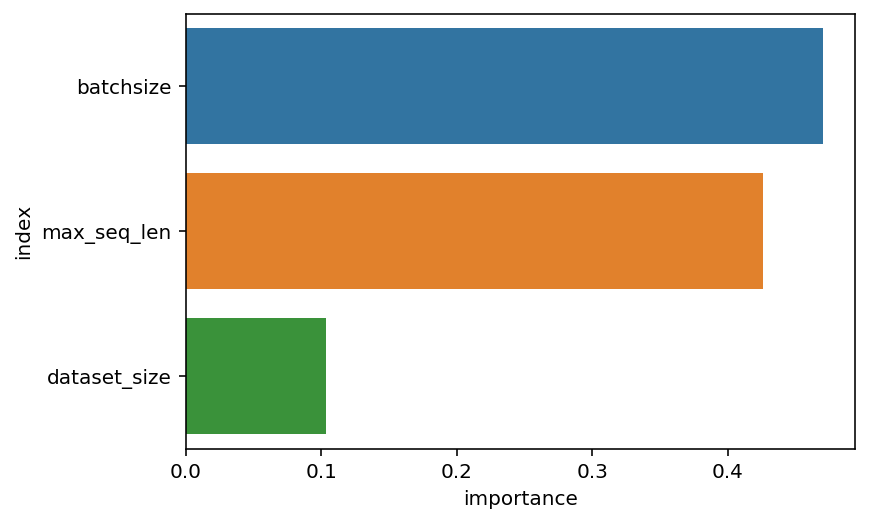

In [133]:
feature_imp(xgboost,X)

In [37]:
forest_model.predict([[30,128,3668]])

array([205.50423484])

In [49]:
forest_model.predict([[50,128,3668]])

array([223.8792789])

In [43]:
url = 'nvidia/nvidia_power_CoLA_32_128.csv'
df, x= power_reading(url)

In [44]:
df.columns

Index(['timestamp', ' utilization.gpu [%]', ' utilization.memory [%]',
       ' memory.total [MiB]', ' memory.used [MiB]', ' memory.free [MiB]',
       ' temperature.gpu', ' power.draw [W]', ' pstate'],
      dtype='object')

In [119]:
#sns.pairplot(df)